In [40]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, ShuffleSplit, KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [42]:
metro = pd.read_csv("./Stations/SGP.csv")

# Cleaning

In [45]:
metro['nearest_datetime'] = pd.to_datetime(metro['nearest_datetime'], format='%Y-%m-%d %H:%M:%S')
#metro['real_departure'] = pd.to_datetime(metro['real_departure'], format='%Y-%m-%d %H:%M:%S')

metro = metro.sort_values(by='destination_name', ascending=False)
metro['destination_name'] = pd.factorize(metro["destination_name"])[0]

metro = metro.sort_values(by='nearest_datetime', ascending=True)

metro["departure_status"] = metro["departure_status"].astype("string")
metro["is_day"] = metro["is_day"].astype(int)
metro['pourc_validations'] = metro['pourc_validations'].fillna(0)

metro = metro.drop(['stop_name', "real_departure", "real_arrival", "ArRTown", "Date", "day_type", "is_bank_holiday", "is_weekend"], axis=1)

# PCA

In [167]:
# Select numerical variables
numerical_vars = metro.select_dtypes(include=['float64'])

# Standardize the numerical variables
scaler = StandardScaler()
numerical_vars_scaled = scaler.fit_transform(numerical_vars)

# Perform PCA
pca = PCA()
pca_results = pca.fit_transform(numerical_vars_scaled)

In [169]:
# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(
    pca_results,
    columns=[f'PC{i+1}' for i in range(pca_results.shape[1])]
)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Output the PCA results and explained variance
print("Explained Variance Ratio:", explained_variance)
print("PCA DataFrame Head:\n", pca_df.head())

Explained Variance Ratio: [0.15821882 0.11726358 0.09985304 0.08634977 0.07399243 0.06648447
 0.06454107 0.05873291 0.0537671  0.05159959 0.04985832 0.04177913
 0.02967797 0.02504181 0.01589125 0.00544781 0.00086782 0.00063311]
PCA DataFrame Head:
         PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.586068 -0.662644 -0.700199 -1.596631 -1.171296  0.576529 -0.967924   
1  0.544750 -0.459196 -0.915655 -2.102657 -1.153164  0.468458 -1.071813   
2  0.349886 -0.209523 -1.282566 -2.825752 -1.199768  0.218943 -1.149894   
3  0.360620 -0.151302 -1.330102 -2.934370 -1.174956  0.213854 -1.174656   
4  0.320843 -0.162124 -1.399676 -2.670069 -1.012044  0.284922 -0.935946   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0 -1.644704  0.561256 -1.370688  0.133561  0.745285  0.655241 -0.476139   
1 -0.863865  1.352971  0.667545 -0.274831  0.986732  0.644836 -0.298236   
2  0.105158  0.254999 -1.383563 -0.911123  0.768250  0.718776  0.345777   


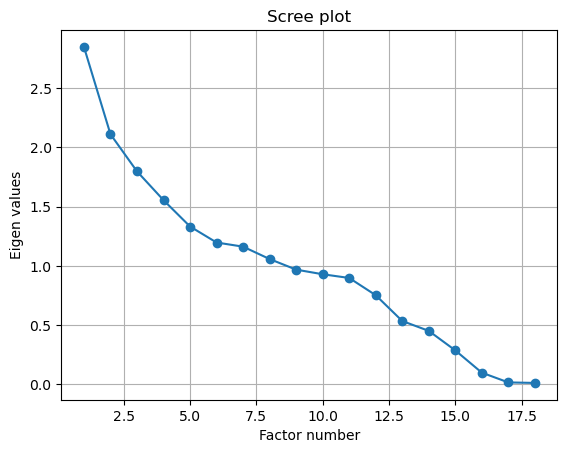

In [171]:
# Eigenvalues (explained variance for each principal component)
eigval = pca.explained_variance_

# Number of components (k)
k = len(eigval)

# Scree plot
plt.plot(np.arange(1, k + 1), eigval, marker='o')
plt.title("Scree plot")
plt.ylabel("Eigen values")
plt.xlabel("Factor number")
plt.grid(True)
plt.savefig('Screeplot_SGP.png', bbox_inches='tight', dpi=300)
plt.show()


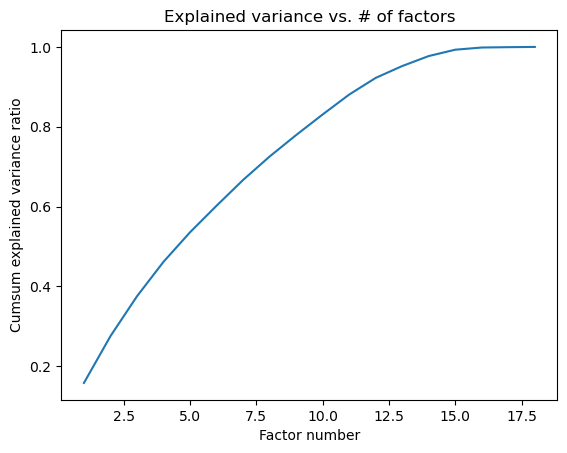

In [172]:
plt.plot(np.arange(1,k+1),np.cumsum(pca.explained_variance_ratio_)) 
plt.title("Explained variance vs. # of factors") 
plt.ylabel("Cumsum explained variance ratio") 
plt.xlabel("Factor number") 
plt.savefig('CumSumPlot_SGP.png', bbox_inches='tight', dpi=300)
plt.show()

In [174]:
## 10 factors picked for expainability

In [177]:
eigval

array([2.8481771 , 2.11092112, 1.79750524, 1.55442606, 1.33197526,
       1.19682067, 1.16183649, 1.05728085, 0.9678888 , 0.9288703 ,
       0.89752491, 0.75208737, 0.53424822, 0.45079035, 0.28606639,
       0.09806878, 0.01562202, 0.01139686])

In [179]:
print(np.cumsum(pca.explained_variance_ratio_))

[0.15821882 0.2754824  0.37533544 0.46168521 0.53567765 0.60216212
 0.66670319 0.72543609 0.77920319 0.83080278 0.8806611  0.92244024
 0.95211821 0.97716002 0.99305127 0.99849908 0.99936689 1.        ]


# Prediction

In [48]:
metro_learn = metro
metro_test = metro

start_date = pd.to_datetime('2024-11-02 00:00:00')
end_date = pd.to_datetime('2025-01-12 23:59:59')

start_date2 = pd.to_datetime('2025-01-13 00:00:00')
end_date2 = pd.to_datetime('2025-01-19 23:59:59')

metro_learn = metro_learn[(metro_learn['nearest_datetime'] >= start_date) & (metro_learn['nearest_datetime'] <= end_date)]
metro_test = metro_test[(metro_test['nearest_datetime'] >= start_date2) & (metro_test['nearest_datetime'] <= end_date2)]


# Logistic Regression

In [ ]:
metro_learn = metro_learn.copy()
metro_learn.drop(['nearest_datetime'], axis=1, inplace=True)  # Drop the original datetime column if not needed
metro_test = metro_test.copy()
metro_test.drop(['nearest_datetime'], axis=1, inplace=True)  # Drop the original datetime column if not needed

In [119]:
metro_learn_X = metro_learn.drop('departure_status', axis=1)  # (exclude target)
metro_learn_Y = metro_learn['departure_status']  # Target variable
metro_learn_Y  = metro_learn_Y.apply(lambda x: 1 if x == 'delayed' else 0)

# Train-test split (80-20 split)
X_train, X_test, Y_train, Y_test = train_test_split(metro_learn_X, 
                                                    metro_learn_Y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=metro_learn_Y)

In [121]:
# %%
#Numerical features => standard scaling 

numeric_features = ['temperature_2m', 'precipitation', 'wind_speed_10m', 'visibility']

numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

In [123]:
# %%
# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(penalty='elasticnet', solver='saga', max_iter=1000)) 
])

In [125]:
# %%
# Define hyperparameter grid for tuning
param_grid = {
    'model__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'model__l1_ratio': [0.1, 0.5, 0.7, 0.9],  # Elastic Net mix
}

In [127]:
# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['temperature_2m',
                                                                          'precipitation',
                                                                          'wind_speed_10m',
                                                                          'visibility'])])),
                                       ('model',
                                        LogisticRegression(max_iter=1000,
                                                           penalty='elasticnet',
                                                           solver='saga'))]),
             param_grid={'model__C': [0.01, 0.1, 1, 10, 100],
                         'model__l1_ratio': [0.1, 0.5, 0.7, 0.9]},
             scoring='f1')

In [128]:
# Best model
best_model = grid_search.best_estimator_
print(best_model.get_params())

{'memory': None, 'steps': [('preprocessor', ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['temperature_2m', 'precipitation',
                                  'wind_speed_10m', 'visibility'])])), ('model', LogisticRegression(C=0.01, l1_ratio=0.1, max_iter=1000, penalty='elasticnet',
                   solver='saga'))], 'verbose': False, 'preprocessor': ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['temperature_2m', 'precipitation',
                                  'wind_speed_10m', 'visibility'])]), 'model': LogisticRegression(C=0.01, l1_ratio=0.1, max_iter=1000, penalty='elasticnet',
                   solver='saga'), 'preprocessor__force_int_remainder_cols': True, 'preprocessor__n_jobs': None, 'preprocessor__remainder': 'drop', 'preprocessor__sparse_threshold': 0.3, 'preprocessor__transformer_weights': None, 'preprocessor__transformers': [('num', StandardScaler(), ['temperature_2m', 'precipit

In [129]:
# %%
metro_test_X = metro_test.drop('departure_status', axis=1)  # Features (exclude target)
metro_test_Y = metro_test['departure_status'] 
metro_test_Y = metro_test_Y.apply(lambda x: 1 if x == 'delayed' else 0)

In [130]:
y_pred_train = best_model.predict(X_test)    #the test set of the learn data
y_pred_test = best_model.predict(metro_test_X)

In [137]:
print(f"Training Accuracy: {accuracy_score(Y_test, y_pred_train):.4f}")
print(f"Test Accuracy: {accuracy_score(metro_test_Y, y_pred_test):.4f}")

Training Accuracy: 0.9744
Test Accuracy: 0.9796


In [139]:
train_pred_vs_true = pd.DataFrame({'True': Y_test, 
                                   'Predicted': y_pred_train})

test_pred_vs_true = pd.DataFrame({'True': metro_test_Y, 
                                  'Predicted': y_pred_test})

In [141]:
conf_matrix = confusion_matrix(metro_test_Y, y_pred_test)
print(conf_matrix)

[[1102    0]
 [  23    0]]


# Random Forest

In [143]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)  #% of missing values
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)  #create result table
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

print(missing_values_table(metro)) 

There are 0 columns that have missing values.
Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []


In [145]:
# Assuming APK_learn is your DataFrame
# Extract the explanatory variables and the target variable
metro_learn_X = metro_learn.drop('departure_status', axis=1)  # Features (exclude target)
metro_learn_Y = metro_learn['departure_status']  # Target variable

# Train-test split (80-20 split)
X_train, X_test, Y_train, Y_test = train_test_split(metro_learn_X, 
                                                    metro_learn_Y, 
                                                    test_size=0.2, 
                                                    random_state=42)


In [147]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Define the parameter grid for GridSearchCV
rf_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [149]:
# Perform GridSearchCV with StratifiedKFold cross-validation
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_cv = GridSearchCV(rf, rf_grid, cv=cv_folds, n_jobs=-1, scoring='accuracy')

In [151]:
rf_cv.fit(X_train, Y_train)

# Output the best hyperparameters found by GridSearchCV
print(f"Best hyperparameters: {rf_cv.best_params_}")

Best hyperparameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [152]:
metro_test_X = metro_test.drop('departure_status', axis=1)  # Features (exclude target)
metro_test_Y = metro_test['departure_status']  # Target variable


In [153]:
# Evaluate the model on the test set
y_pred_train = rf_cv.predict(X_test)
y_pred_test = rf_cv.predict(metro_test_X)

# Print the accuracy on training and test sets
print(f"Training Accuracy: {accuracy_score(Y_test, y_pred_train):.4f}")
print(f"Test Accuracy: {accuracy_score(metro_test_Y, y_pred_test):.4f}")

# Create DataFrames for plotting prediction vs true values
train_pred_vs_true = pd.DataFrame({'True': Y_test, 
                                   'Predicted': y_pred_train})

test_pred_vs_true = pd.DataFrame({'True': metro_test_Y, 
                                  'Predicted': y_pred_test})

Training Accuracy: 0.9948
Test Accuracy: 0.9982


In [154]:
# Generate confusion matrix
conf_matrix = confusion_matrix(metro_test_Y, y_pred_test)
print(conf_matrix)


[[  21    2]
 [   0 1102]]


In [155]:
metro_test['departure_status'].value_counts()

departure_status
onTime     1102
delayed      23
Name: count, dtype: Int64